In [1]:
import sys
sys.path.append(r"C:\Users\edwin\Desktop\SQCLab\Python\Script")

import matplotlib.pyplot as plt
import numpy as np
import lmfit
from LogReader import LogHandler

In [2]:
def post_rotate(ydata):
    from scipy.optimize import minimize_scalar
    def rotate_complex(iq, angle):
        return (iq) * np.exp(1j * np.pi * angle/180)

    def std_q(y, rot_agl_):
        iq = rotate_complex(y, rot_agl_)
        return np.std(iq.imag)
    res = minimize_scalar(lambda agl:std_q(ydata, agl), bounds=[0, 360])
    rotation_angle = res.x
    ydata = np.real(rotate_complex(ydata,rotation_angle))
    return ydata

## decay sine

def decaysine_resid(params, xdata, ydata = None, std = None):
    
    amp = params['amp'].value
    freq = params['freq'].value
    phase = params['phase'].value
    decay = params['decay'].value
    offset = params['offset'].value

    y_model = offset + amp * np.sin(2*np.pi*freq*xdata + phase) * np.exp(-xdata/decay)
    if ydata is None:
        return y_model
    return y_model - ydata

def decaysine_guess(xdata, ydata):
    fourier = np.fft.fft(ydata)
    fft_freqs = np.fft.fftfreq(len(ydata), d=xdata[1]-xdata[0])
    fft_phases = np.angle(fourier)
    sorted_fourier = np.sort(fourier)
    max_ind = np.argwhere(fourier == sorted_fourier[-1])[0][0]
    if max_ind == 0:
        max_ind = np.argwhere(fourier == sorted_fourier[-2])[0][0]
    max_freq = np.abs(fft_freqs[max_ind])
    max_phase = fft_phases[max_ind]

    yrange = np.max(ydata) - np.min(ydata)
    xrange = np.max(xdata) - np.min(xdata)
    params = lmfit.create_params(
        # amp = dict(value = yrange/2, min = 0.25*yrange, max = 2*yrange),
        amp = dict(value = yrange/2),
        freq = dict(value = max_freq, min = 0.1/xrange, max = 15/xrange),
        decay = dict(value = xrange/4, min = 0.0001),
        phase = dict(value = max_phase, min = -np.pi, max = np.pi),
        offset = dict(value = np.mean(ydata), min = np.min(ydata), max = np.max(ydata))
    )
    return params

def expdecay_resid(params, xdata, ydata = None):
    amp = params['amp'].value
    decay = params['decay'].value
    offset = params['offset'].value

    y_model = offset + amp*np.exp(-xdata/decay)
    if ydata is None:
        return y_model
    return y_model - ydata

def expdecay_guess(xdata, ydata):
    xrange = np.max(xdata) - np.min(xdata)
    params = lmfit.create_params(
        amp = dict(value = ydata[0] - ydata[1]),
        decay = dict(value = xrange/4, min = 0),
        offset = dict(value = ydata[-1])
    )
    return params

In [3]:
log = LogHandler(r'C:\Users\SQC\Desktop\ZCU\ZCU_Data\Test065\2024\05\Data_0505\Test065_T2R_001@-1.585mA.hdf5')
x,_,y,xname,_,yname = log.output()
y = post_rotate(y[0])
# y = np.abs(y[0])
# y = np.angle(y[0])
x=x*1e6

model1 = lmfit.Minimizer(decaysine_resid,decaysine_guess(x,y), fcn_args = (x,), fcn_kws={'ydata': y})
# model1 = lmfit.Minimizer(expdecay_resid,expdecay_guess(x,y), fcn_args = (x,), fcn_kws={'ydata': y})
o1 = model1.minimize(method = 'leastsq')
lmfit.report_fit(o1)
r_squared = 1- (o1.residual.var()/np.var(y))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 50
    # variables        = 5
    chi-square         = 0.00661721
    reduced chi-square = 1.4705e-04
    Akaike info crit   = -436.505257
    Bayesian info crit = -426.945142
[[Variables]]
    amp:     0.02787605 +/- 0.00667342 (23.94%) (init = 0.03657336)
    freq:    0.93658198 +/- 0.06430283 (6.87%) (init = 0.6666667)
    decay:   1.21246304 +/- 0.56052526 (46.23%) (init = 0.3675)
    phase:   0.34347434 +/- 0.24720083 (71.97%) (init = 0.2742284)
    offset:  1.22414852 +/- 0.00183048 (0.15%) (init = 1.228113)
[[Correlations]] (unreported correlations are < 0.100)
    C(freq, phase)   = -0.7913
    C(amp, decay)    = -0.7812
    C(amp, phase)    = -0.3633
    C(amp, offset)   = -0.3086
    C(amp, freq)     = +0.2698
    C(decay, phase)  = +0.2655
    C(freq, decay)   = -0.1697
    C(decay, offset) = +0.1386
    C(phase, offset) = +0.1072


Text(0.95, 0.95, '$T_2$R = 1.212+/-0.561 $\\mu$s\n    $\\Delta$ = 0.94+/-0.06 MHz\n    $R^2$ = 0.516')

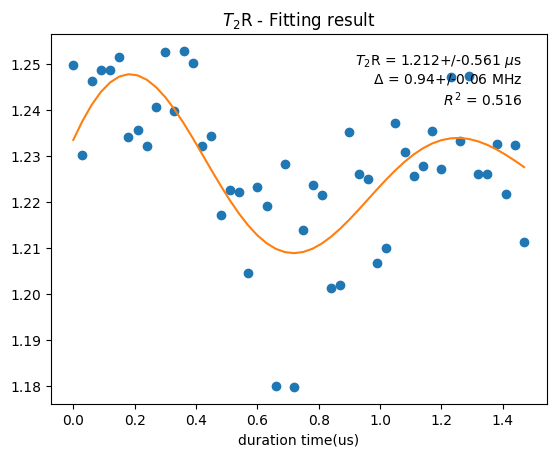

In [4]:
fig, ax = plt.subplots()
plt.ticklabel_format(style = 'sci', scilimits = (-3, 3))
ax.set_title('$T_2$R - Fitting result')
ax.plot(x,y,'o',x,y+o1.residual)
ax.set_xlabel('duration time(us)')
textstr = \
    f"$T_2$R = {o1.uvars['decay']:.3f} $\mu$s\n\
    $\Delta$ = {o1.uvars['freq']:.2f} MHz\n\
    $R^2$ = {r_squared:.3f}"
ax.text(0.95, 0.95, textstr, transform = ax.transAxes, va = 'top', ha = 'right')

In [ ]:
ci= lmfit.conf_interval(model1, o1, sigmas = [3])
lmfit.printfuncs.report_ci(ci)
from pprint import pprint